In [45]:
# imports
import typing
import os
import math
import sys
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import genfromtxt
from numpy.lib import recfunctions as rfn
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Math, Latex
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# colab config
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/cs470')

# Data Preprocessing

## Data Loading

The dataset was downloaded from Kaggle. It contains 32 Columns of 1,000,000 entries. Since it is 216.59 MB, it may take time to load.

_in this project, "label" will refer to column titles, not the value of the `fraud_bool` column_

In [47]:
parsed_data = pd.read_csv("Base.csv") # load csv from drive
display(parsed_data[3:10])
classification = parsed_data["fraud_bool"].astype(np.float32)
labels = parsed_data.keys()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
5,1,0.3,0.143921,-1,30,30,0.028231,-0.748282,AD,732,...,0,200.0,0,INTERNET,4.815073,windows,0,1,0,7
6,1,0.7,0.321554,-1,152,30,0.030680,-0.278994,AB,876,...,0,1500.0,0,INTERNET,1.558977,windows,1,1,0,7
7,1,0.9,0.064817,-1,18,50,0.034557,-1.265721,AB,901,...,0,200.0,1,INTERNET,2.637472,linux,0,1,0,7
8,1,0.7,0.065938,-1,64,40,0.020691,-1.442082,AB,933,...,0,1500.0,0,INTERNET,2.175419,windows,1,1,0,7
9,1,0.9,0.700096,-1,60,40,0.016809,-1.070271,AB,1176,...,0,200.0,0,INTERNET,24.040726,windows,0,1,0,7


Our dataset is very imbalanced. This reflects the fact that fraudulence is fairly rare in the real world.

In [48]:
Latex(f'In the complete data set, {classification.sum()} are fraud ({100*classification.sum()/len(classification):.3f}%)')

<IPython.core.display.Latex object>

# One-hot vectorization

Machine learning algorithms have a hard time understanding strings. To confront this, we replace a column of multiple unique string values with multiple columns for each unique category. These columns contain a boolean to indicate which category it was. This is alternatively known as a _One-hot_.

In [49]:
# one-hotify labels
labels_categorical = ["payment_type", "employment_status", "housing_status", "source", "device_os"] # list that contains columns to be vectorized
labels_vectorized = []
for label in labels_categorical:
    label_index = parsed_data.columns.get_loc(label)
    column_vectorized = pd.get_dummies(parsed_data[label])
    for label_vectorized in column_vectorized:
        # new label joins the category with the original column name
        label_vectorized_new = label + "_" + label_vectorized
        parsed_data.insert(
            label_index,
            label_vectorized_new,
            column_vectorized[label_vectorized])
        labels_vectorized.append(label_vectorized_new)
    del parsed_data[label]
# prove that removal occurred and that new columns were added
assert("payment_type" not in parsed_data.columns and "device_os" not in parsed_data.columns and "device_os_windows" in parsed_data.columns)

# Minimum-Maximum Normalization

The backpropagation algorithm will eventually attempt to normalize the range of values within a column to become from 0 to 1. We can save time by preprocessing the data beforehand, shaving seconds if not minutes off of training.

In [50]:
# minimum-maximum normalization
normalized_features = pd.DataFrame(MinMaxScaler().fit_transform(parsed_data),columns=parsed_data.columns)
display(normalized_features[3:10])

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type_AE,payment_type_AD,...,session_length_in_minutes,device_os_x11,device_os_windows,device_os_other,device_os_macintosh,device_os_linux,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
3,1.0,1.00,0.159510,0.0,0.053613,0.500,0.000243,0.111493,0.0,0.0,...,0.035074,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.0,1.0
4,1.0,1.00,0.596414,0.0,0.510490,0.500,0.000057,0.114854,0.0,0.0,...,0.054951,0.0,0.0,0.0,1.0,0.0,1.0,0.666667,0.0,1.0
5,1.0,0.25,0.143920,0.0,0.072261,0.250,0.000360,0.115048,0.0,1.0,...,0.066917,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1.0
6,1.0,0.75,0.321554,0.0,0.356643,0.250,0.000391,0.118701,0.0,0.0,...,0.029448,0.0,1.0,0.0,0.0,0.0,1.0,0.666667,0.0,1.0
7,1.0,1.00,0.064816,0.0,0.044289,0.500,0.000440,0.111021,0.0,0.0,...,0.041859,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.0,1.0
8,1.0,0.75,0.065937,0.0,0.151515,0.375,0.000264,0.109649,0.0,0.0,...,0.036541,0.0,1.0,0.0,0.0,0.0,1.0,0.666667,0.0,1.0
9,1.0,1.00,0.700096,0.0,0.142191,0.375,0.000214,0.112542,0.0,0.0,...,0.288158,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,1.0


# Data Partitioning

Finally, the data will be partitioned into both training and evaluation subsets. As suggested in the NeurIPS paper, we use the first 10 months of data for training and the most recent two for evaluation.

In [62]:
data_training = normalized_features[normalized_features['month'] <= 10./12.]
labels_training = data_training['fraud_bool']

display(data_training[3:10])
data_evaluation = normalized_features[normalized_features['month']  > 10/12]
labels_evaluation  = data_evaluation['fraud_bool']

# these aren't features
_ = [data_evaluation.pop(c) for c in {"month", "fraud_bool"}]
_ = [data_training.pop(c) for c in {"month", "fraud_bool"}]

print(f"Training on {100*(len(data_training)/len(parsed_data)):.2f}% of the data.")

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type_AE,payment_type_AD,...,session_length_in_minutes,device_os_x11,device_os_windows,device_os_other,device_os_macintosh,device_os_linux,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
96846,1.0,0.750,0.033833,0.000000,0.067599,0.250,0.000060,0.111753,0.0,0.0,...,0.072066,0.0,1.0,0.0,0.0,0.0,1.0,1.000000,0.0,0.428571
96847,1.0,1.000,0.150642,0.000000,0.384615,0.375,0.000156,0.119099,0.0,0.0,...,0.077434,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.428571
96848,1.0,1.000,0.183750,0.000000,0.855478,0.750,0.000256,0.111119,0.0,1.0,...,0.108442,0.0,0.0,0.0,1.0,0.0,1.0,0.666667,0.0,0.428571
96849,1.0,0.625,0.224905,0.000000,0.750583,0.250,0.000106,0.115198,0.0,1.0,...,0.064789,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.428571
96850,1.0,0.000,0.749541,0.000000,0.200466,0.125,0.037429,0.090798,0.0,0.0,...,0.096421,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.428571
96851,1.0,0.625,0.108179,0.000000,0.179487,0.500,0.000217,0.113170,0.0,0.0,...,0.226342,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.428571
96852,1.0,0.750,0.023326,0.322917,0.011655,0.250,0.012022,0.114128,0.0,1.0,...,0.192916,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.0,0.428571


Training on 79.50% of the data.


# Data exploration

We first separate out the fraudulent and nonfraudulent rows into their own frames:

In [52]:
fraud = []
fraud_not = []
for rowix,row in normalized_features.iterrows():
    # faught too hard with pandas to use the boolean column as index
    if classification[rowix]:
        fraud.append(row)
    else:
        fraud_not.append(row)
fraud = pd.DataFrame(fraud,columns=normalized_features.columns)
fraud_not = pd.DataFrame(fraud_not,columns=normalized_features.columns)

Now, we will do some plots of the bivariate and univariate distributions of some pairs of columns. Ember thinks this is useful for exploration, but it takes a few minutes to run.

/Users/ember/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


IndexError: pop from empty list

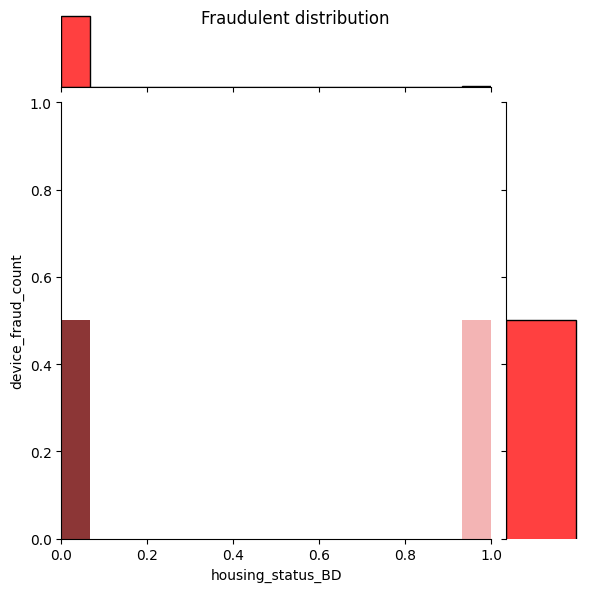

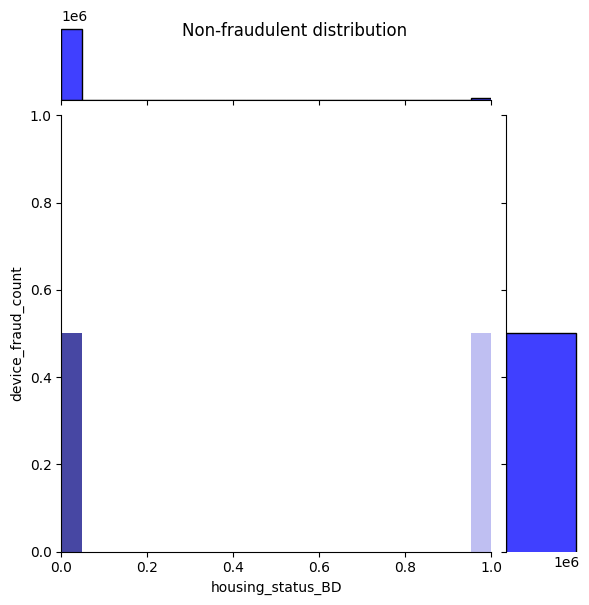

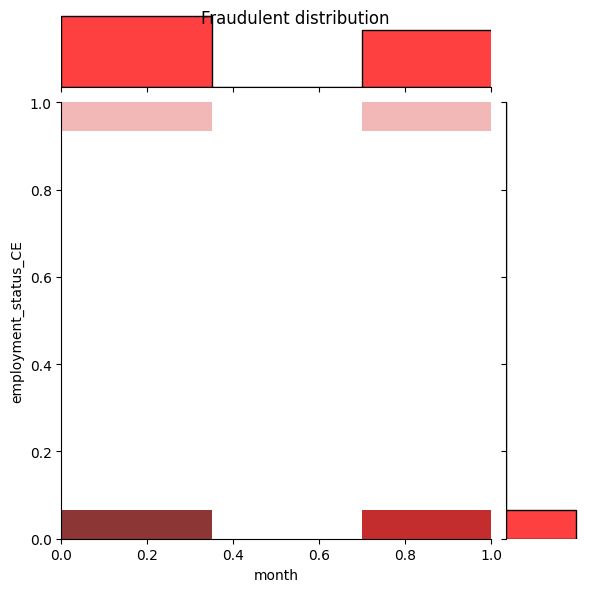

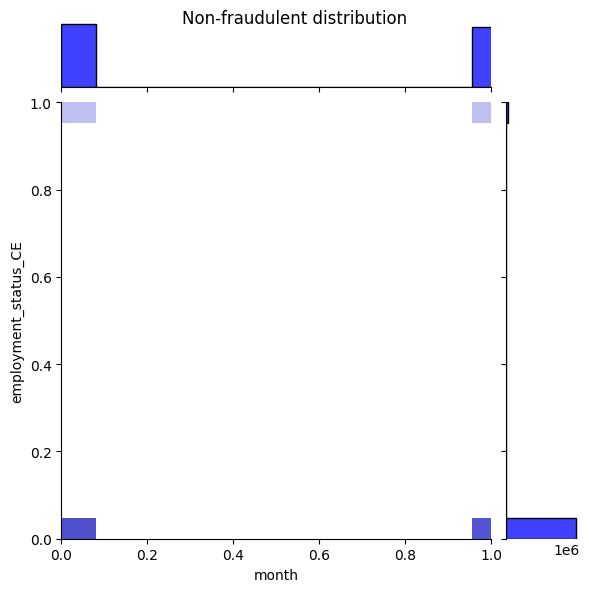

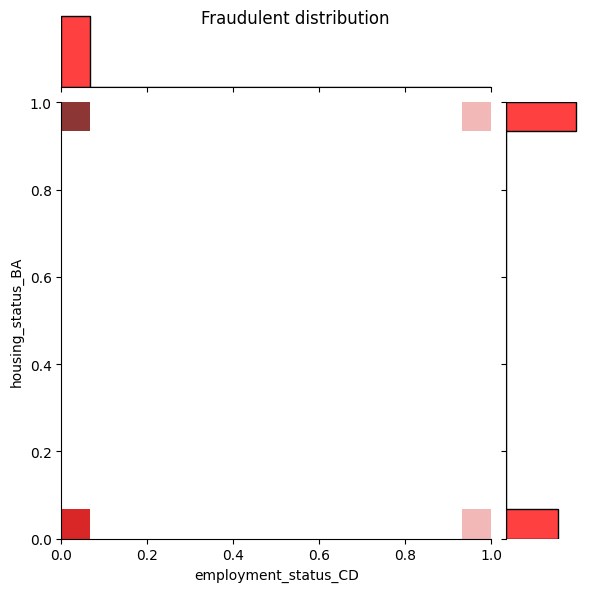

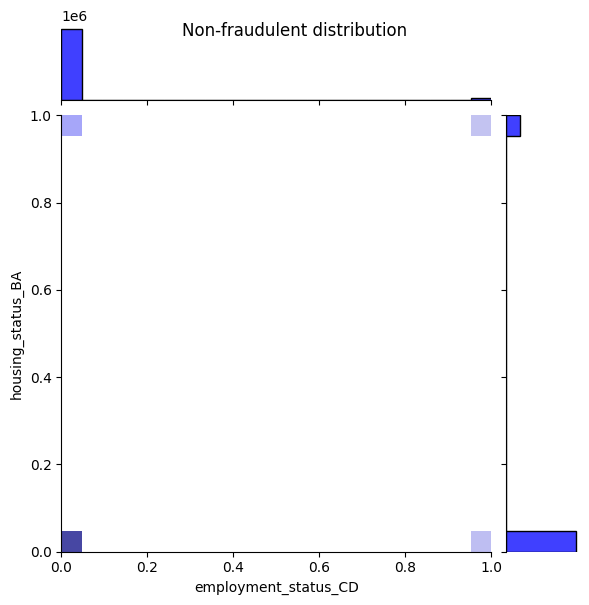

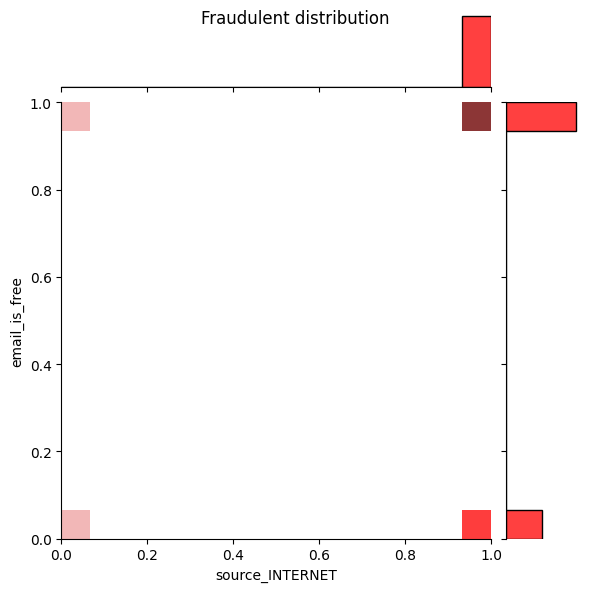

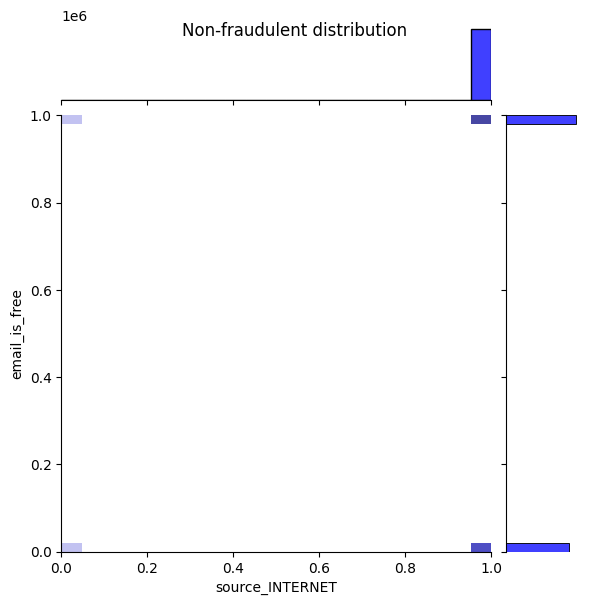

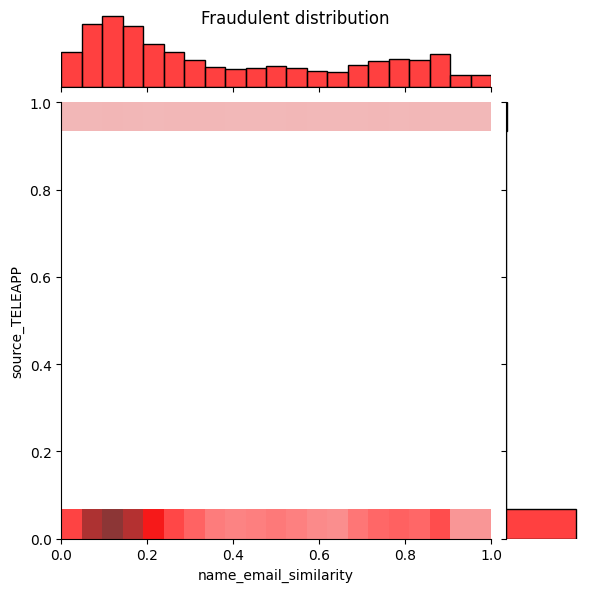

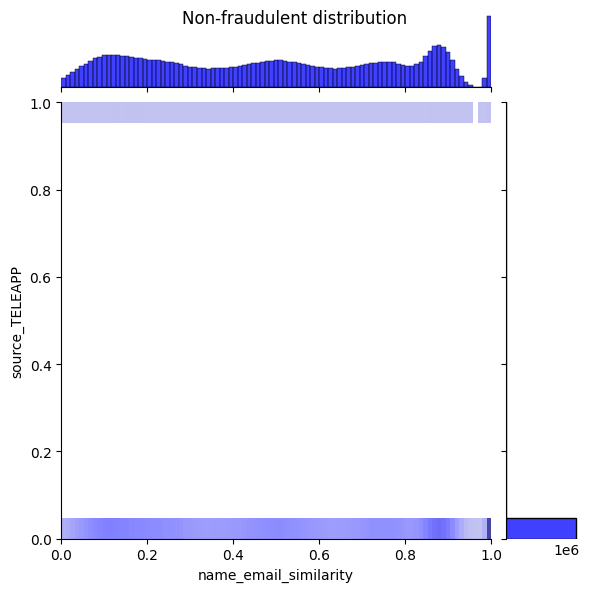

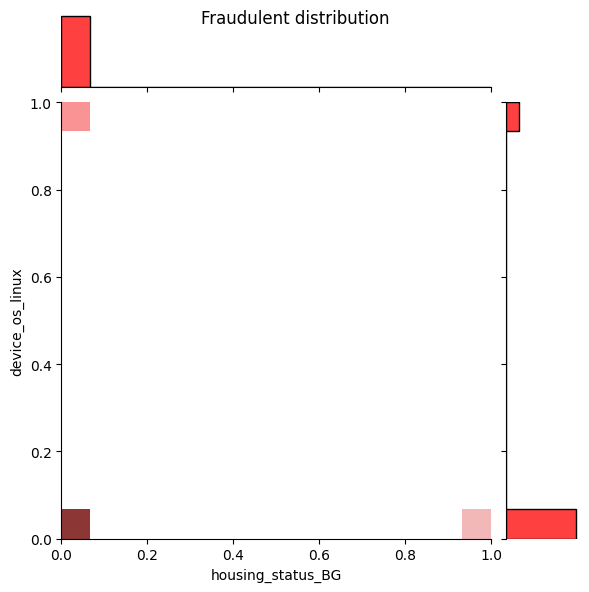

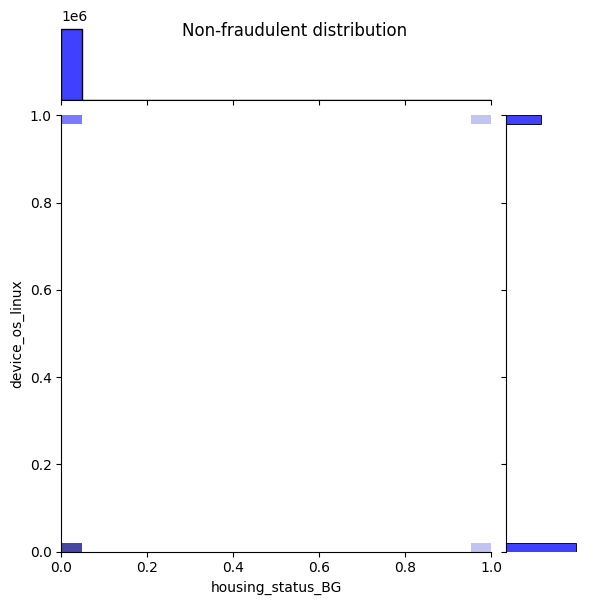

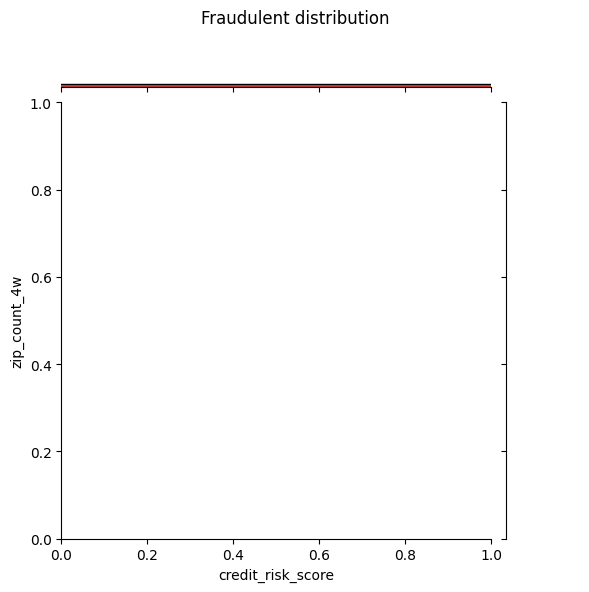

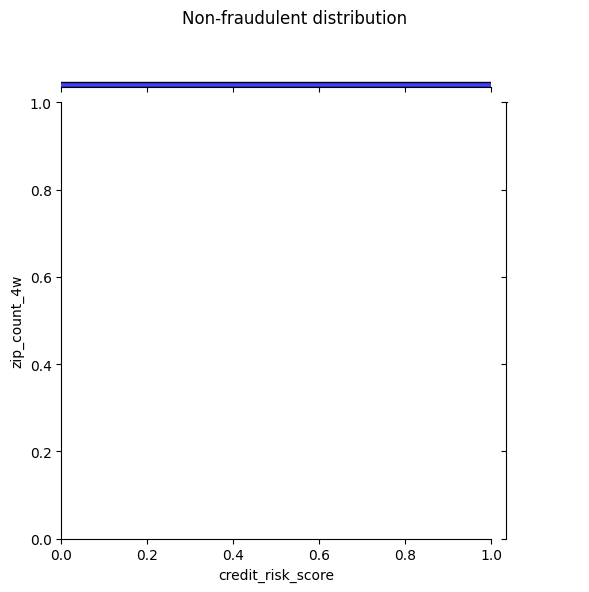

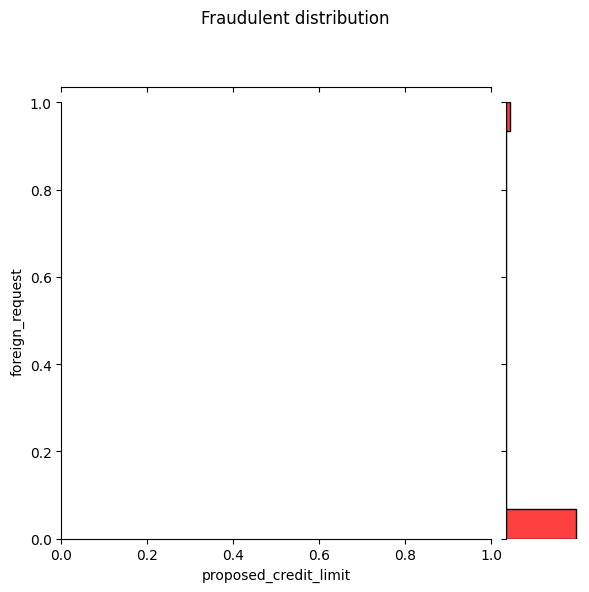

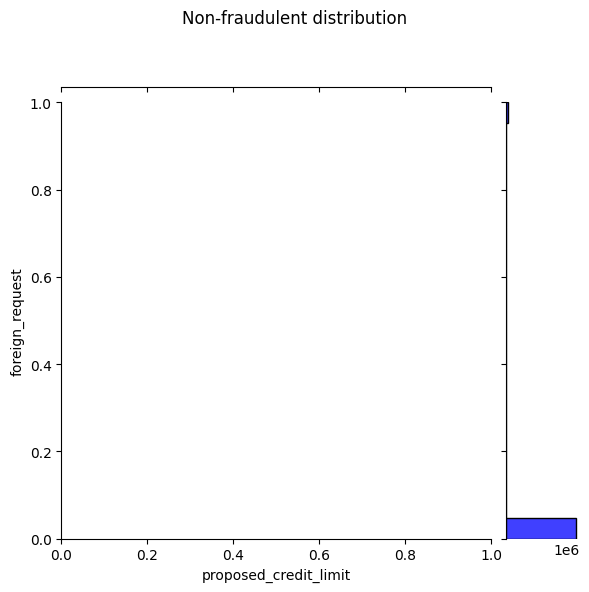

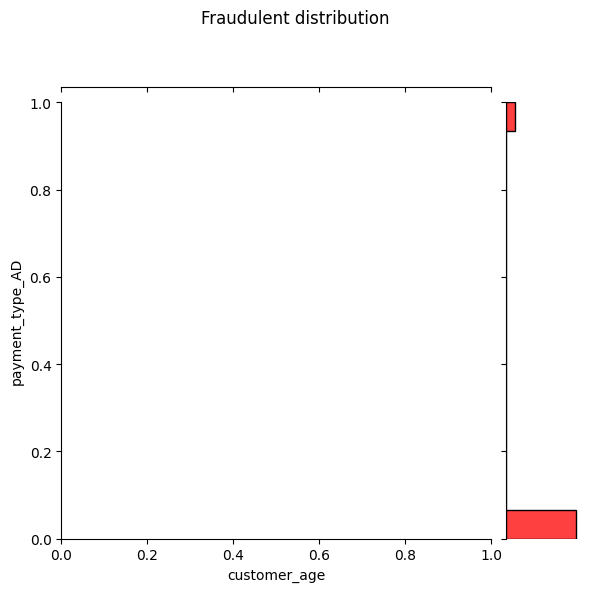

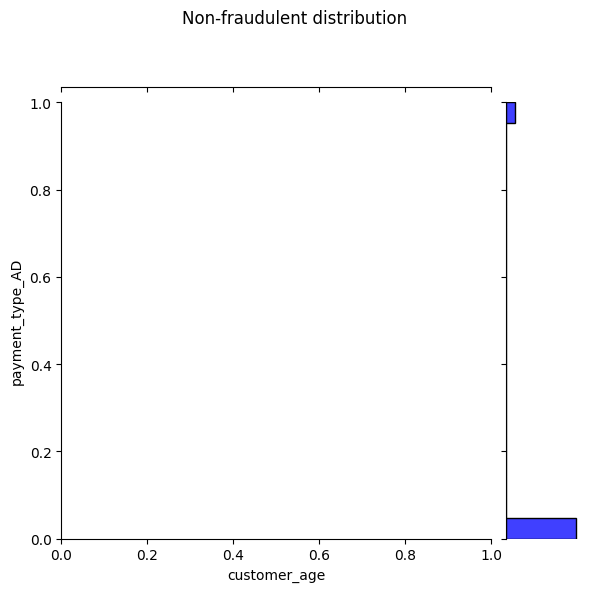

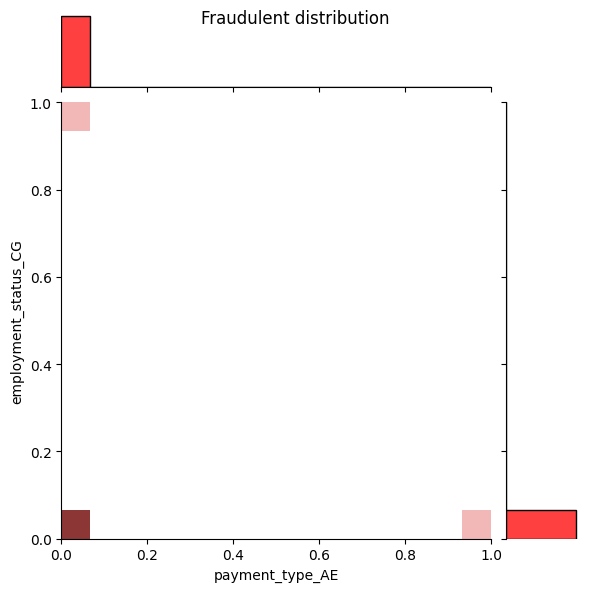

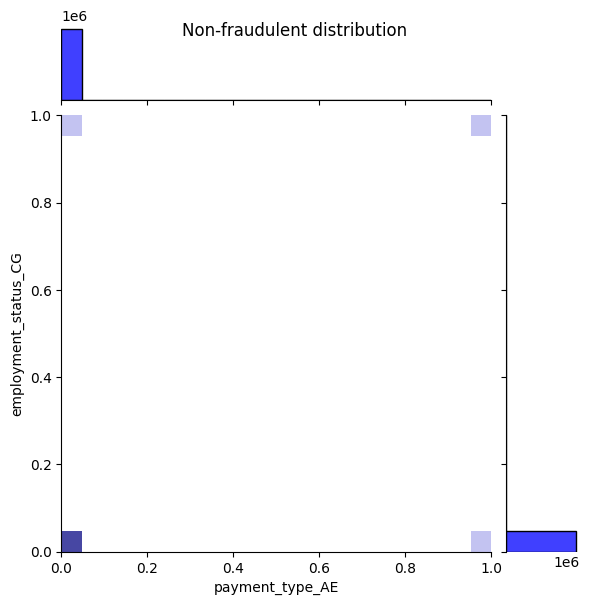

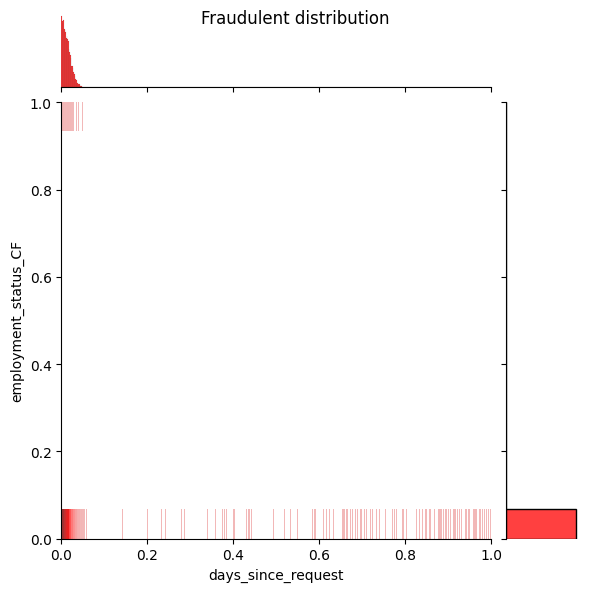

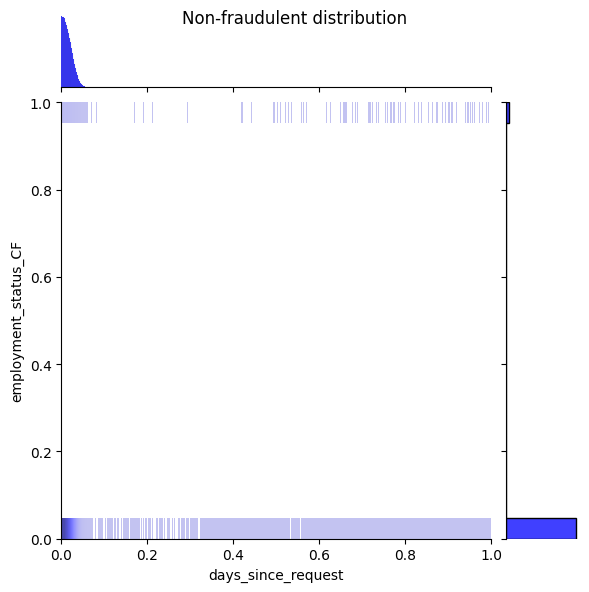

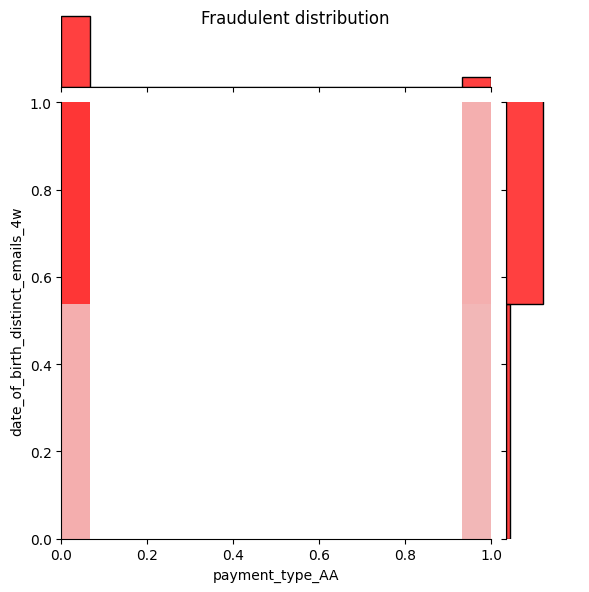

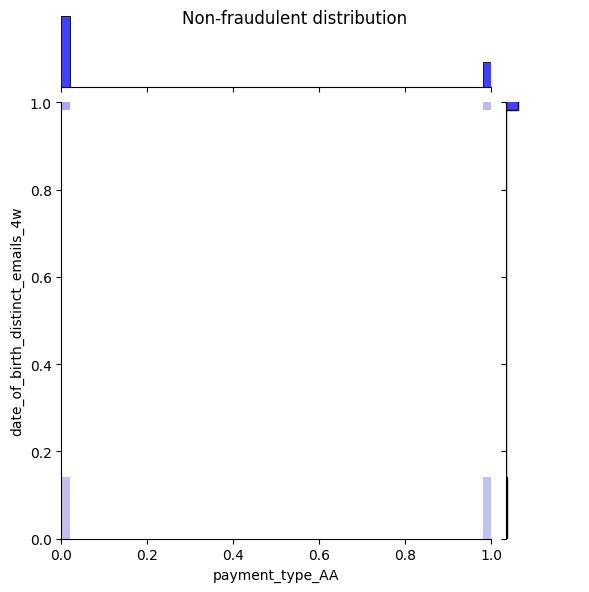

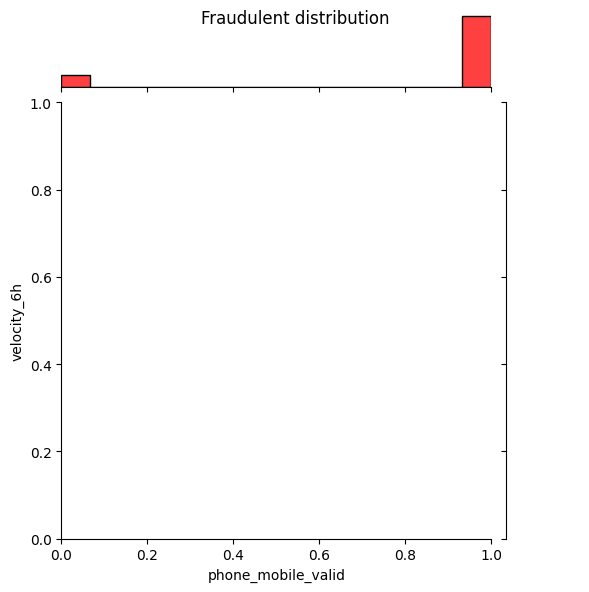

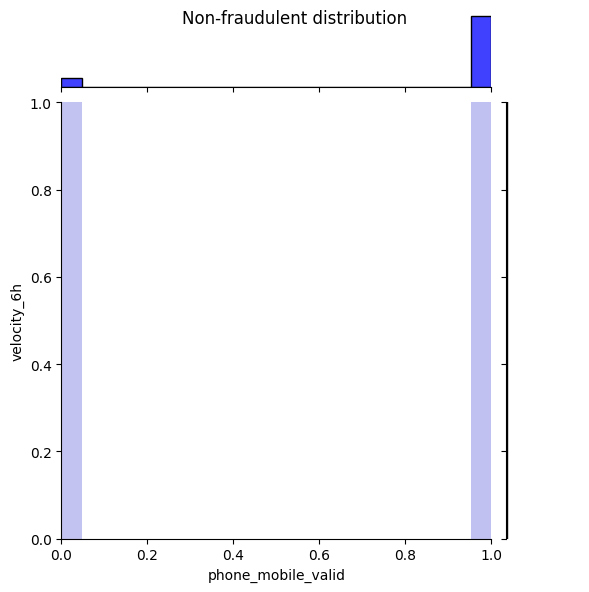

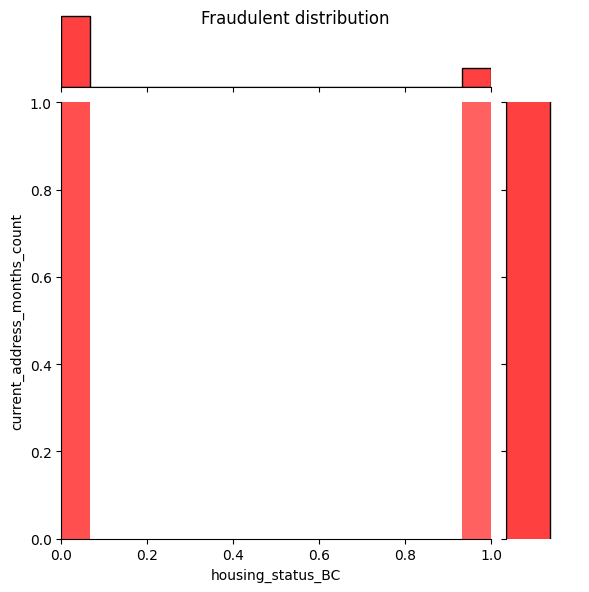

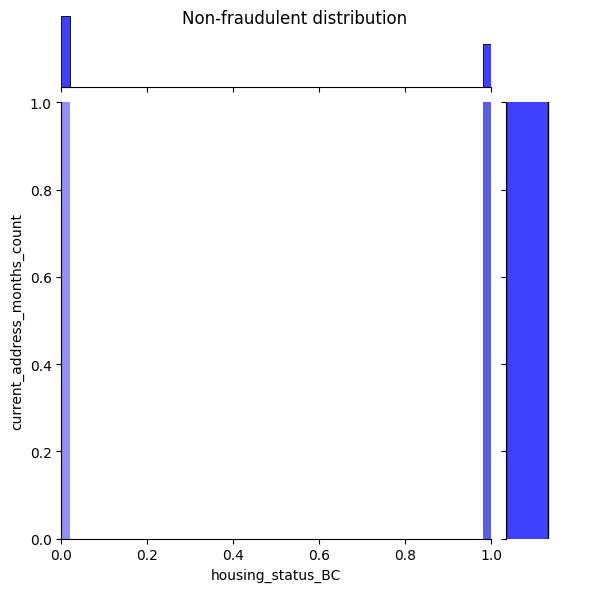

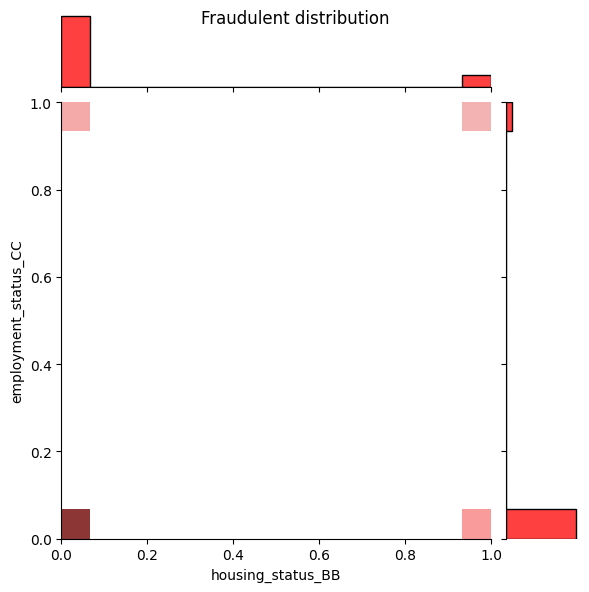

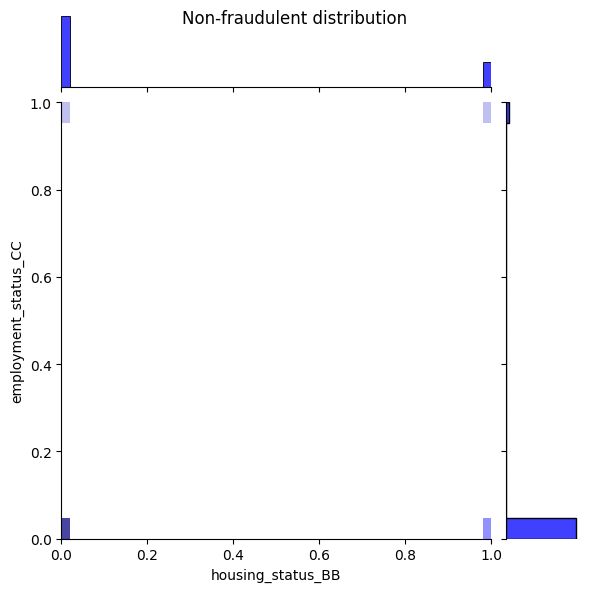

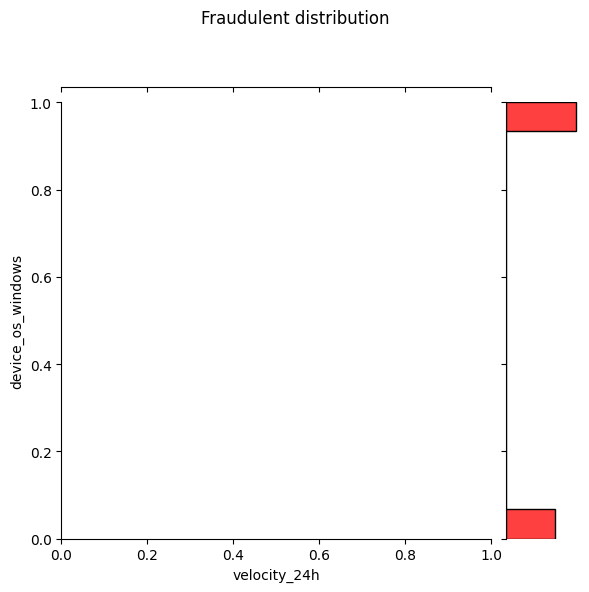

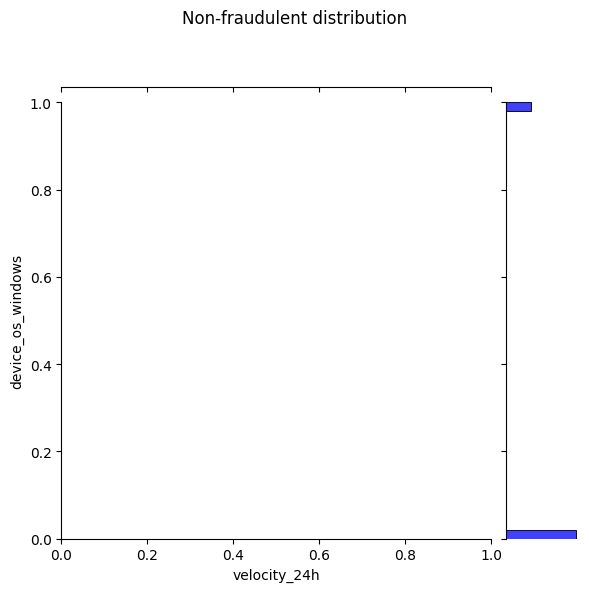

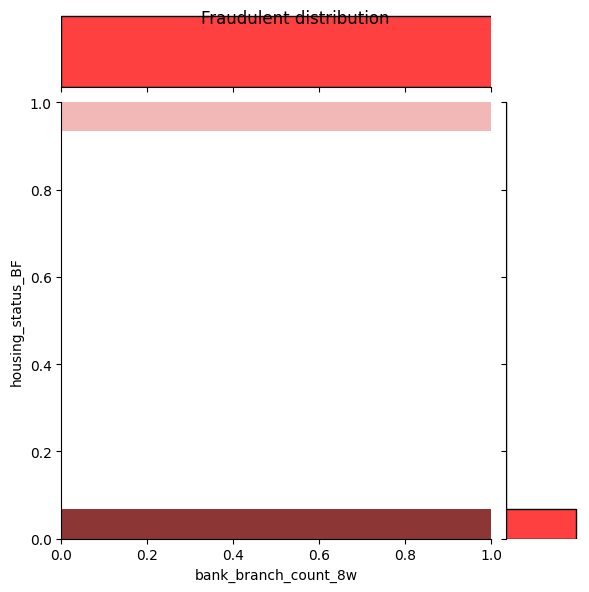

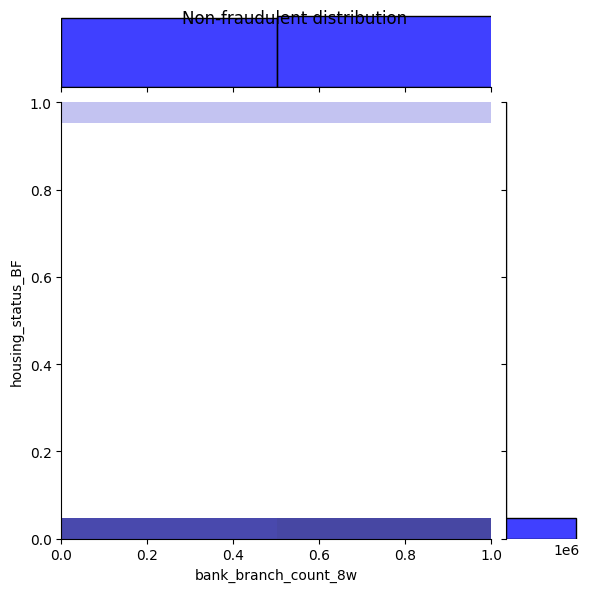

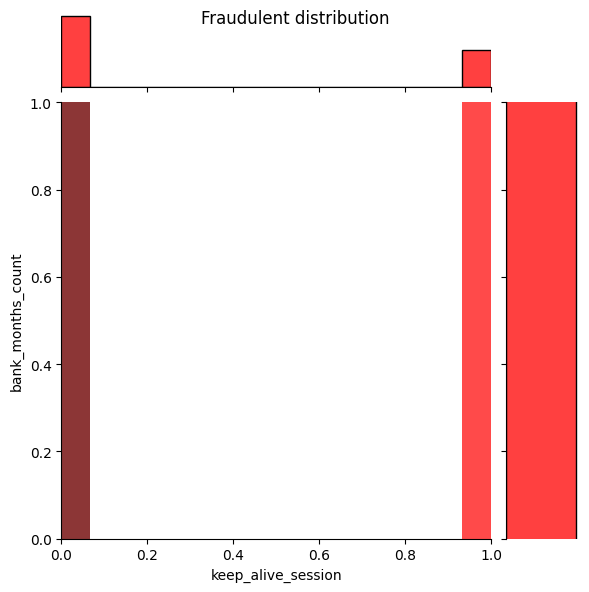

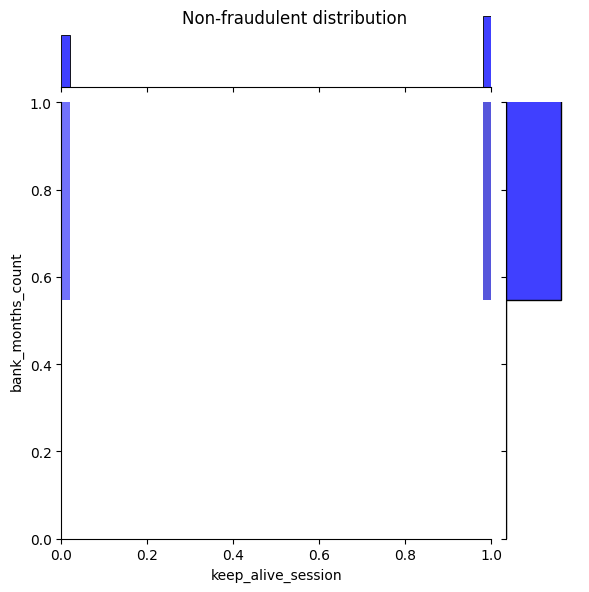

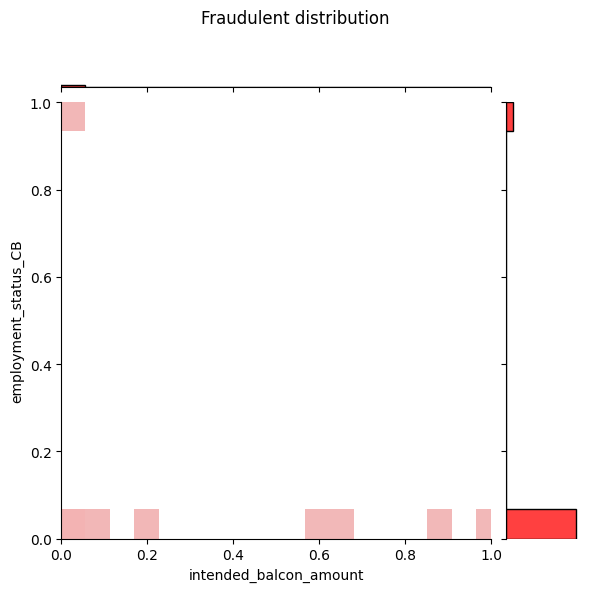

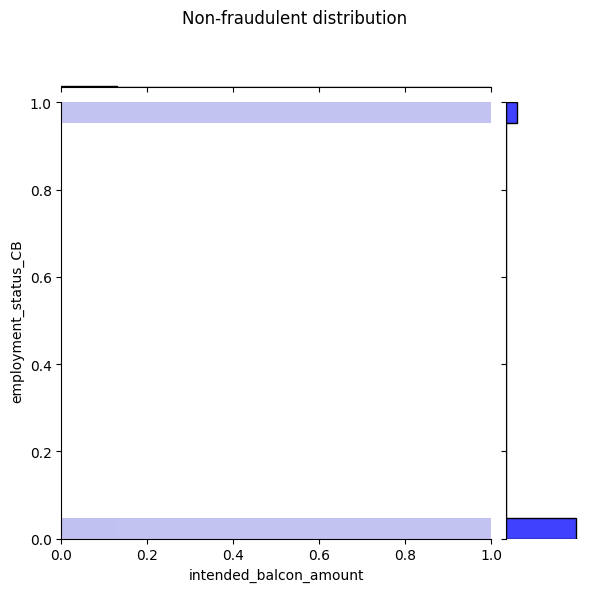

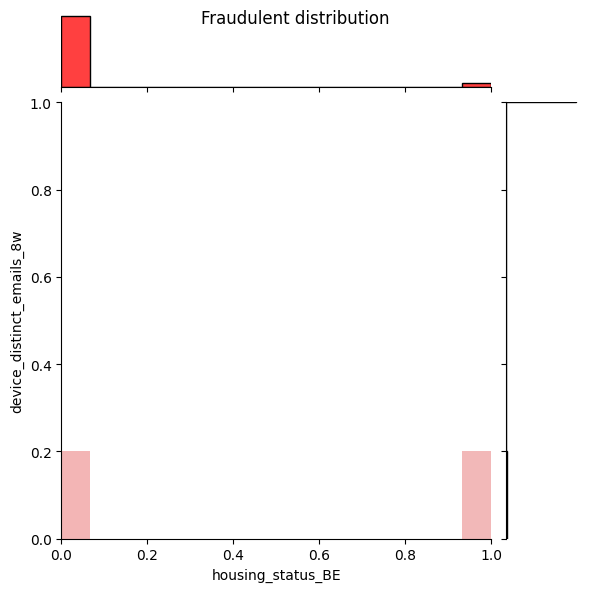

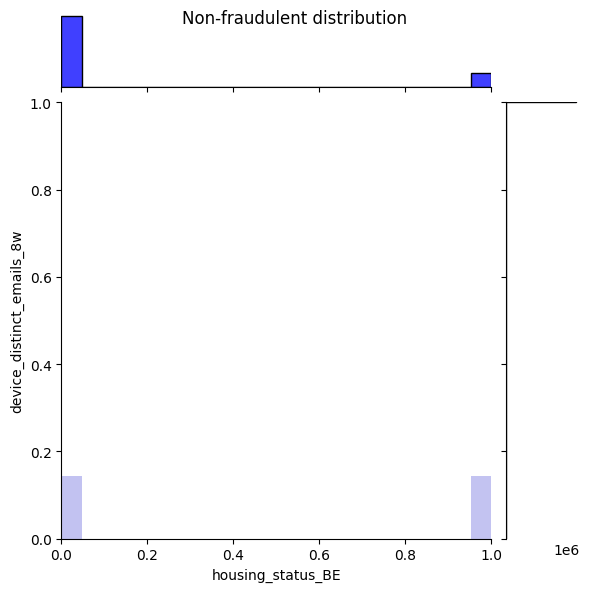

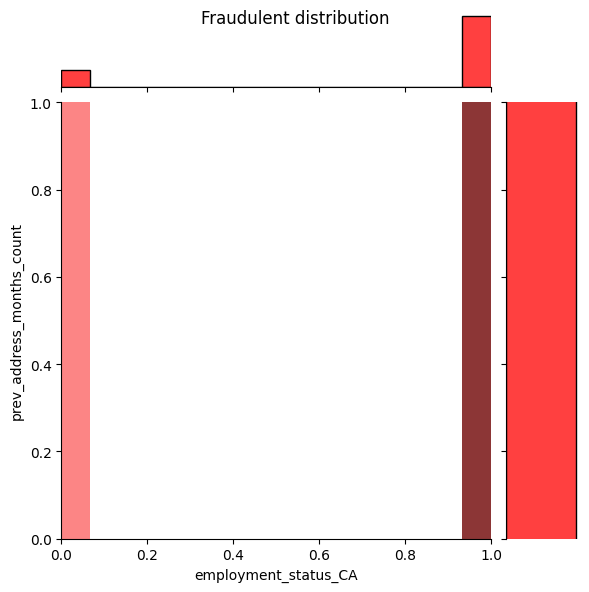

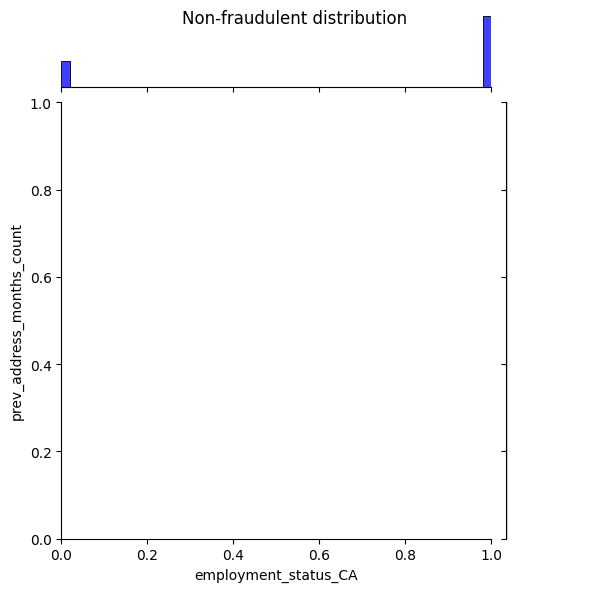

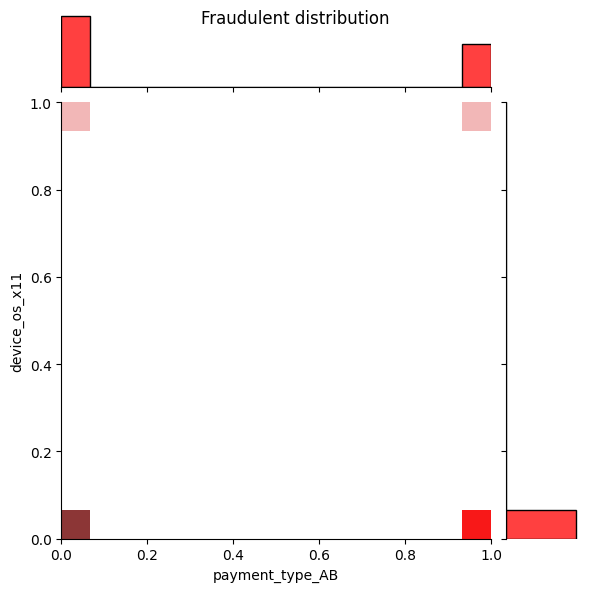

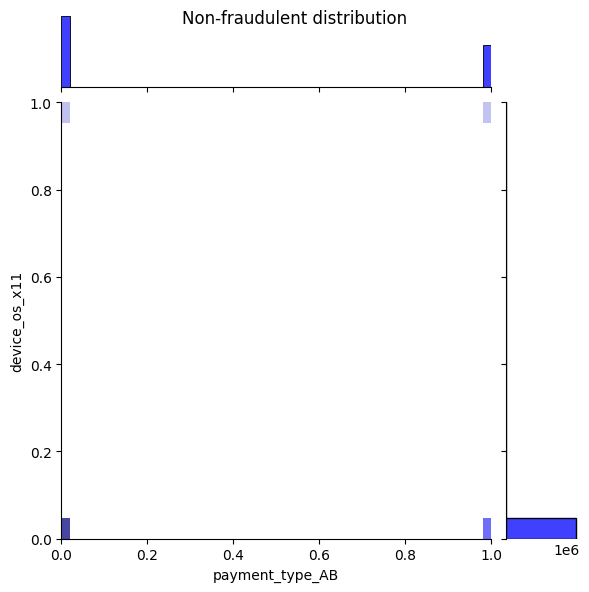

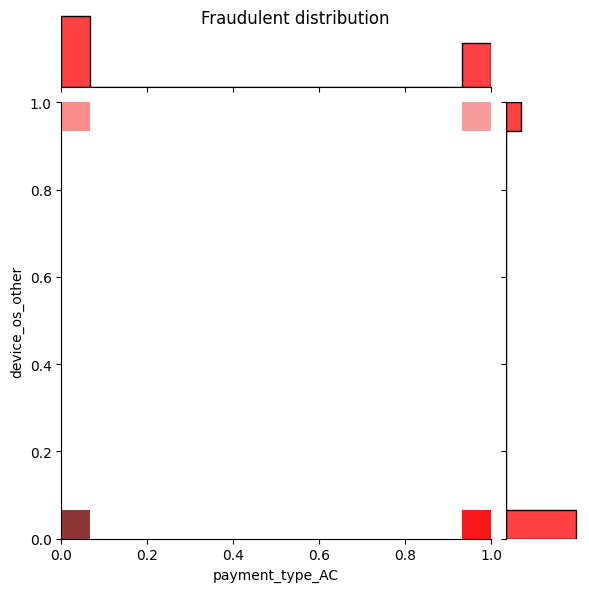

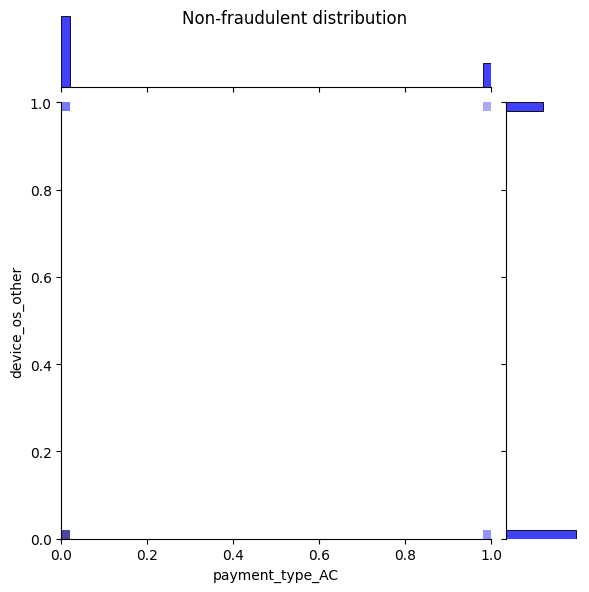

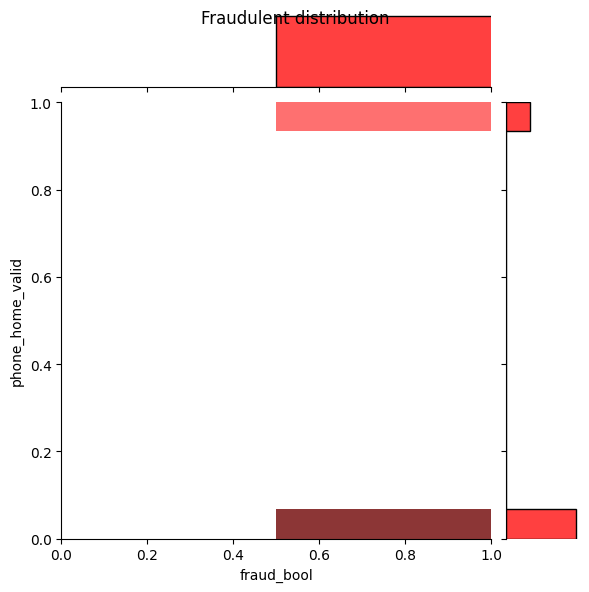

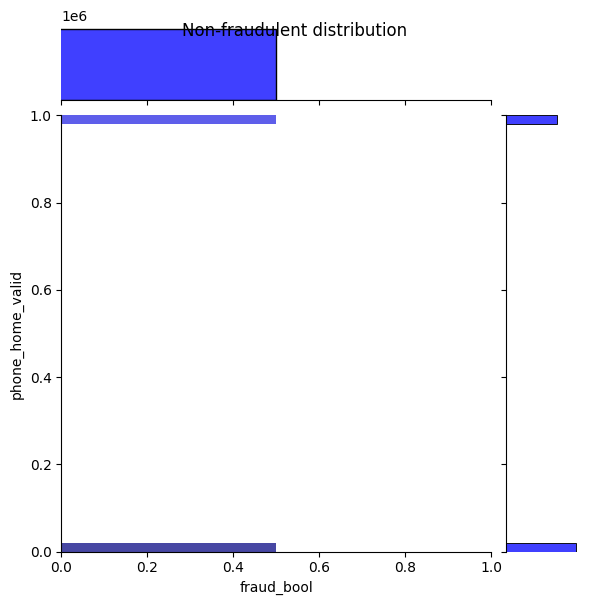

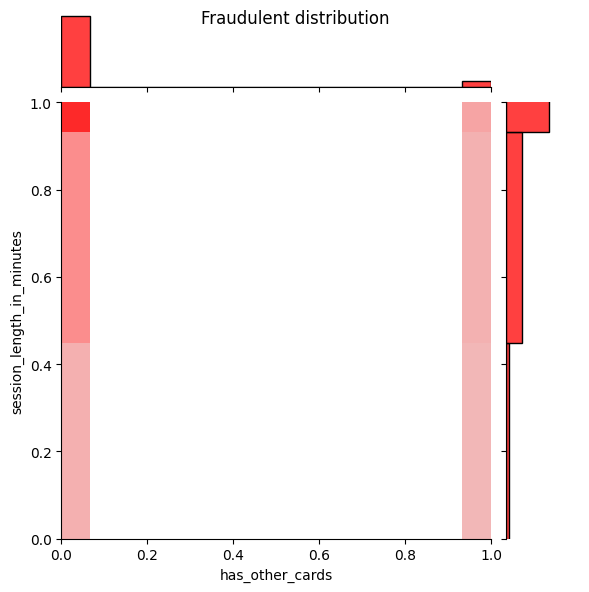

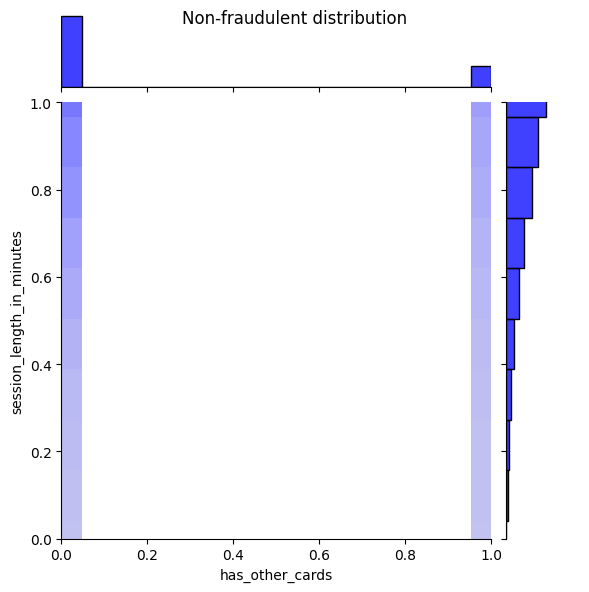

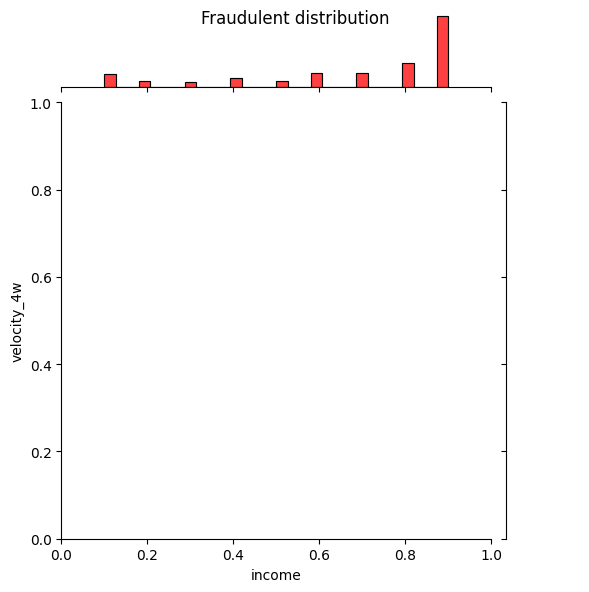

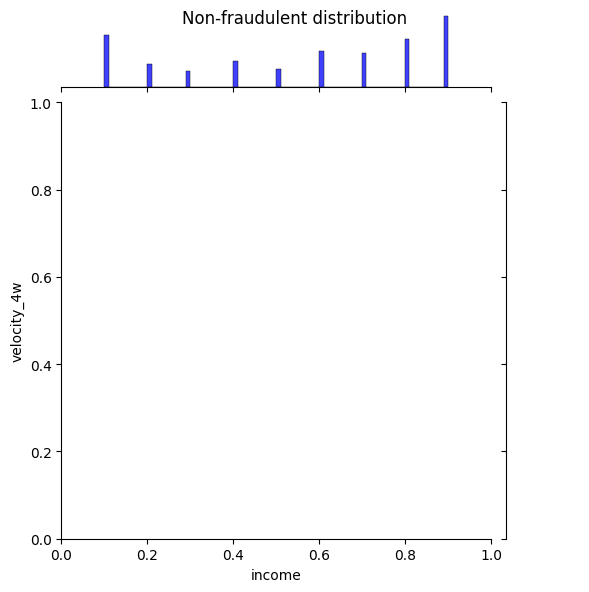

In [54]:
labelscopy = list(normalized_features.columns)
random.shuffle(labelscopy)
# plots two features' distributions on a single plot
def distribution(dataset, labels, label_0, label_1):
    args = { 'kind':'hist', 'xlim':(0,1), 'ylim':(0,1) }
    g1 = sns.jointplot(x=fraud.loc[:,label_0], y=fraud.loc[:,label_1], color = 'red', **args)
    plt.suptitle("Fraudulent distribution")
    g2 = sns.jointplot(x=fraud_not.loc[:,label_0], y=fraud_not.loc[:,label_1], color='blue',
                **args)
    plt.suptitle("Non-fraudulent distribution")

try:
    while len(labelscopy) != 0:
        label_0 = labelscopy.pop()
        label_1 = labelscopy.pop()
        distribution(normalized_features, classification, label_0, label_1)
except IndexError:
    pass

In [63]:
plt.close()

# Model Design

We will be using a simple ANN for this project. The data is categorical (remapped to one-hots) and numerical (now min-max normalized), with no spatial significance. Ember wanted to experiment with neural decision forests, but there was no interest.

In [82]:
# model design

model = keras.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(data_training.shape[-1],)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [83]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.AUC(curve="PR", num_thresholds=50), tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               26624     
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 190,977
Trainable params: 190,977
Non-tr

# Training

In [84]:
weight_for_1 = labels_training.sum() / len(labels_training)
weight_for_0 = 1 - weight_for_1
class_weight = {0.: weight_for_0, 1.: weight_for_1}
display(class_weight)
history = model.fit(
    x=data_training,
    y=labels_training,
    class_weight=class_weight,
    epochs=1)

{0.0: 0.9897470279462987, 1.0: 0.010252972053701372}

Epoch 1/10


2022-12-13 01:38:02.608733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24844/24844 [==============================] - 369s 15ms/step - loss: 0.0011 - false_positives_7: 24.0000 - false_negatives_7: 8151.0000 - true_negatives_7: 786814.0000 - true_positives_7: 0.0000e+00 - auc_7: 0.0103 - binary_accuracy: 0.9897 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 2/10
24844/24844 [==============================] - 361s 15ms/step - loss: 9.5008e-04 - false_positives_7: 0.0000e+00 - false_negatives_7: 8151.0000 - true_negatives_7: 786838.0000 - true_positives_7: 0.0000e+00 - auc_7: 0.0107 - binary_accuracy: 0.9897 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 3/10
24844/24844 [==============================] - 367s 15ms/step - loss: 9.4226e-04 - false_positives_7: 0.0000e+00 - false_negatives_7: 8151.0000 - true_negatives_7: 786838.0000 - true_positives_7: 0.0000e+00 - auc_7: 0.0107 - binary_accuracy: 0.9897 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 4/10
24844/24844 [==============================] - 374s 15ms/step - loss: 9.3760e-04

In [2]:
model.save("model_0.h5")

NameError: name 'model' is not defined

In [ ]:
for datapoint in random.choices(data_evaluation, k=5):
    print(f"Model predicts {model.predict([datapoint])[0][0]} for {datapoint}")
for datapoint in random.choices(fraud, k=5):
    print(f"Model predicts {model.predict([datapoint])[0][0]} for fraudulent {datapoint}")
for datapoint in random.choices(fraud_not, k=5):
    print(f"Model predicts {model.predict([datapoint])[0][0]} for non-fraudulent {datapoint}")

history = model.evaluate(data_evaluation, labels_evaluation)
display(history)

KeyError: 5436